In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
import torch.optim as optim
from PIL import Image, ImageEnhance
import cv2

In [2]:
class CenterCrop224(object):
    
    def __init__(self, output_size=224):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image):
        img = np.array(image)
        h, w = img.shape[:2]
        sz = self.output_size
        
        if h == w: 
            return cv2.resize(img, (sz, sz), cv2.INTER_AREA)
        
        elif h > w:
            scaling_factor = sz / w
            x_shape = sz
            y_shape = int(h * scaling_factor)
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((y_shape - sz) / 2)
            img_reshaped = img_reshaped[offset:offset + sz, :, :]
            
        else :
            scaling_factor = sz / h
            x_shape = int(w * scaling_factor) 
            y_shape = sz
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((x_shape - sz) / 2)
            img_reshaped = img_reshaped[:, offset:offset+sz, :]
        return img_reshaped


In [3]:
transform = transforms.Compose([CenterCrop224(), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])

# transform = transforms.Compose([VGG16_Weights.IMAGENET1K_V1.transforms])
# transform = VGG16_Weights.IMAGENET1K_V1.transforms

In [4]:
img = cv2.cvtColor(cv2.imread('puffer.JPEG'), cv2.COLOR_BGR2RGB)

img = transform(img)
# img = Image.open('puffer.JPEG')
# print(img.size)

# img = img.transform([244], transforms.InterpolationMode.BILINEAR)

In [5]:
image = transforms.ToPILImage()(img).convert("RGB")

In [6]:
import json
f_labels = open('imagenet_class_index.json', 'r')
labels = json.load(f_labels)
f_labels.close()

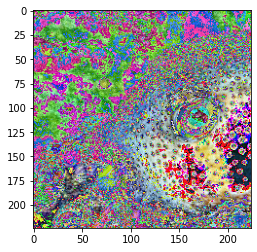

In [7]:
plt.imshow(image)

### Conv Network

In [8]:
class ConvVgg16(nn.Module):
    def __init__(self, save_switches=False):
        super().__init__()
        
        self.save_switches = save_switches
        # indices of Conv2d layres
        self.modules_no = []
        
        self.features = vgg16(pretrained=True).features
        
        for i, feature in enumerate(self.features) :
            if isinstance(feature, nn.MaxPool2d):
                self.features[i] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices = True)
            
            elif isinstance(feature, nn.Conv2d):
                self.modules_no.append(i)
            
        self.avgpool = vgg16(pretrained=True).avgpool
        
        self.classifier = vgg16(pretrained=True).classifier
                        
        
    def forward (self, x) :
        conv_results = {}
        maxpool_indices = {}
        for i, layer in enumerate(self.features):
            
            if isinstance(layer, nn.MaxPool2d):
                x, index = layer(x)
                maxpool_indices[i] = index
                
            else :
                x = layer(x)
            
            if isinstance(layer, nn.Conv2d):
                conv_results[i] = x
            
        
            
        x = self.avgpool(x)
        x = x.flatten()
        x = self.classifier(x)
        
        
        if not self.save_switches :
            return x    
            
        return x, conv_results, maxpool_indices
    

### Deconv

In [9]:
class ConvDeconvVGG16(nn.Module) :
    def __init__(self) :
        
        super().__init__()
        
        
        self.conv_model = ConvVgg16(save_switches=True)

        
        self.conv_indices = []
        self.maxpool_indices = []
        
        module_list = []
        
        for i, layer in enumerate(self.conv_model.features) :
            if isinstance(layer, nn.Conv2d):
                module_list.append(nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size, stride=layer.stride, padding=layer.padding))
                module_list[i].weight.data = layer.weight.data
                self.conv_indices.append(i)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_list.append(nn.MaxUnpool2d(kernel_size=2, stride=2))
                self.maxpool_indices.append(i)
                
            elif isinstance(layer, nn.ReLU):
                module_list.append(nn.ReLU(inplace=True))
        
        module_list.reverse()
        self.module_list = nn.ModuleList(module_list)
     
    
    def __zero_activation(self, y, k) :
        if k == 'channel' :
            y_sum = y.sum(axis=1).sum(axis=1)
            y_argmax = y_sum.argmax().item()
            y_zerod = torch.zeros_like(y)
            y_zerod[y_argmax, :, :] = y[y_argmax, :, :]
            return y_zerod
        
        elif k == 'pixel' :
            y_idx = y.argmax().item()
            y_max = y.max().item()
            y_zerod = torch.zeros_like(y).flatten()
            y_zerod[y_idx] = y_max
            return y_zerod.reshape(y.shape)
        
        elif k == 'vector' :
            pass
    
        
    def forward(self, x, layer_ix) :
        
        conv_pred_vector, conv_results, switches  = self.conv_model(x)
        conv_pred = conv_pred_vector.argmax().item()
        
        y = conv_results[self.conv_indices[layer_ix]]
        y = self.__zero_activation(y, 'channel')

        
        
        for i, layer in enumerate(self.module_list[(30 - self.conv_indices[layer_ix]):]) :
            if isinstance(layer, nn.MaxUnpool2d):
                y = layer(y, switches[self.conv_indices[layer_ix] - i])
            else :
                y = layer(y)
                
        ret = {"pred_prob" : conv_pred_vector, "pred" : conv_pred, "conv_results": conv_results, "deconv" : y}
        return ret
        
        

In [10]:
model = ConvDeconvVGG16()

/home/shreya/.venvs/gen-3.9.7/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/shreya/.venvs/gen-3.9.7/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
out = model(img, 7)
print(f"Class : {out['pred']}: {labels[str(out['pred'])][1]}")

Class : 397: puffer


In [20]:
img_out = out['deconv'].permute(1, 2, 0).detach().cpu().numpy()

In [21]:
img_out = (img_out - img_out.min()) / (img_out.max() - img_out.min())
# img_out = (img_out * 255).astype(np.uint8)

In [22]:
# # Histogram equalization on img_out
# img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
# img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
# img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])

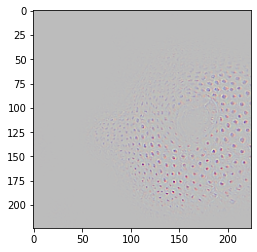

In [23]:
plt.imshow(img_out)